In [2]:
import argparse
import json
import os
import re
import cv2
import h5py
import numpy as np
import tifffile
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import gaussian_filter, median_filter, shift, uniform_filter1d
from scipy.signal import convolve
from tqdm import tqdm


def extract_pixel_resolution(metadata_str, default_resolution):
    print("Extracting pixel resolution...")
    # Extract resolution of recordfile from raw tiffmetadata
    pixel_resolution = None
    for line in metadata_str.split("\n"):
        if "pixelResolutionXY" in line:
            match = re.search(r'pixelResolutionXY": \[(.*?)\]', line)
            if match:
                pixel_resolution = match.group(1)
                break

    if pixel_resolution:
        pixel_resolution = [int(x) for x in pixel_resolution.split(",")]
        print("pixelResolutionXY found in metadata.")
    else:
        print("pixelResolutionXY not found in metadata. Using default resolution.")
        pixel_resolution = default_resolution

    return pixel_resolution

In [3]:
from dataclasses import dataclass, field

@dataclass
class SimulationParameters:
    input: str
    output: str = "../results/"
    SimDescription: str = "default"
    darkrate: float = 0.02
    IMsz: list = field(default_factory=lambda: [45, 125])
    frametime: float = 0.0023
    brightness: float = 0.2
    bleachTau: int = 360
    T: int = 10000
    motionAmp: float = 3
    tau: float = 0.027
    activityThresh: float = 0.12
    sigma: float = 1.33
    photonScale: int = 600
    nsites: int = 30
    minDistance: float = 1.5
    minspike: float = 0.3
    maxspike: float = 4.0
    spikeAmp: int = 2
    numTrials: int = 1
    writetiff: bool = True

args = SimulationParameters(input="/data/zstacks/scan_00001-REF_Ch2.ome.tif")
params = vars(args)

In [4]:
fn, output_path, seed= args.input, args.output, 0

In [94]:
    np.random.seed(seed)

    # Create output directory
    if not os.path.exists(output_path):
        print("Creating output directory...")
        os.makedirs(output_path)
    print("Output directory created at", output_path)

    # Intialize kernel
    kernel = np.exp(-np.arange(0, 8, params["frametime"] / params["tau"]))
    sw = np.ceil(3 * params["sigma"]).astype(int)
    skernel = np.zeros((2 * sw + 1, 2 * sw + 1, sw + 1))
    skernel[sw, sw, int(sw / 2)] = 1
    skernel = gaussian_filter(
        skernel, [params["sigma"], params["sigma"], params["sigma"] / 2]
    )
    skernel *= (skernel >= skernel[sw].min()) / np.max(skernel)

    if "REGISTERED" not in fn:
        print(f"Loading {fn}...")
        metadata_str = ScanImageTiffReader(fn).metadata()
        params["IMsz"] = extract_pixel_resolution(
            metadata_str, [125, 45])[::-1]

    print(f"Loading {fn}...")

    GT = {}  # Groundtruth dictionary
    # TOOD: Read the Z stack. No longer a XYT rather XYZ.
    mov = tifffile.imread(fn)
    IMVol_Avg = mov[
        3:-3, :, :
    ]  # IMVol_Avg take mov which is 3d average accross time from ZXYT.
    BG = np.percentile(IMVol_Avg[~np.isnan(IMVol_Avg)], 30)
    IMVol_Avg = np.maximum(np.nan_to_num(IMVol_Avg) - BG, 0)
    IMVol_Avg /= np.percentile(IMVol_Avg, 99)
    selR = np.arange(
        (IMVol_Avg.shape[1] - params["IMsz"][0]) // 2,
        (IMVol_Avg.shape[1] + params["IMsz"][0]) // 2,
    )
    selC = np.arange(
        (IMVol_Avg.shape[2] - params["IMsz"][1]) // 2,
        (IMVol_Avg.shape[2] + params["IMsz"][1]) // 2,
    )
    selZ = np.arange(
        5, IMVol_Avg.shape[0] - 5
    )  # selZ select middle 5 frames. Remove top 5 and bottom 5 frames.

    tmp = median_filter(
        IMVol_Avg, size=(3, 3, 2)
    )  # Change IMavg to IMVol_Avg size with  size=(3, 3, 1) or size=(3, 3, 2) Not sure if filtering in Z would help.
    tmp = tmp > min(np.percentile(tmp, 97), 4 * np.mean(tmp))

    # Set certain regions to False
    mD = max(int(params["minDistance"]), 0)

    # Set slices for the depth (selZ)
    tmp[: selZ[0] + mD, :, :] = False
    tmp[selZ[-1] + 1 - mD:, :, :] = False

    # Set slices for the rows (selR)
    tmp[:, : selR[0] + mD, :] = False
    tmp[:, selR[-1] + 1 - mD:, :] = False

    # Set slices for the columns (selC)
    tmp[:, :, : selC[0] + mD] = False
    tmp[:, :, selC[-1] + 1 - mD:] = False

    tmp = np.transpose(np.where(tmp))

    if params["nsites"] > 0:
        if params["minDistance"] <= 0:
            releaseSites = tmp[
                np.random.choice(tmp.shape[0], params["nsites"], replace=False)
            ]
            zz, rr, cc = np.unravel_index(releaseSites, mov.shape)
            dz, dr, dc = np.random.rand(3, len(rr)) - 0.5
        else:
            releaseSites = np.empty((params["nsites"], 3))
            for j in range(params["nsites"]):
                trial = 0
                while True:
                    i = np.random.choice(len(tmp))
                    candidate = tmp[i] + np.random.rand(3) - 0.5
                    if j == 0 or np.all(
                        np.linalg.norm(releaseSites[:j] - candidate, axis=1)
                        >= params["minDistance"]
                    ):
                        releaseSites[j] = candidate
                        tmp = np.delete(tmp, i, 0)
                        break
                    trial += 1
                    if trial > 10000:
                        raise ValueError(
                            f"Failed to place site {j+1}/{params['nsites']} at a minimum "
                            f"distance of {params['minDistance']} within 10000 trials."
                        )
            zz, rr, cc = zip(*releaseSites)
            dz, dr, dc = releaseSites.T - np.array([zz, rr, cc])
        # Save Coordinates
        # + 1  Adjust index for Python's 0-based indexing
        GT["R"] = rr + dr - selR[0]
        # + 1  Adjust index for Python's 0-based indexing
        GT["C"] = cc + dc - selC[0]

        GT["Z"] = zz + dz - selZ[0]

    else:
        GT["R"], GT["C"], GT["Z"] = [], [], []

    # Simulate synapses
    for trialIx in tqdm(
        range(1, params["numTrials"] + 1), desc="Simulation Progress"
    ):
        fnstem = (
            f'SIMULATION_{os.path.basename(fn)[:11]}{params["SimDescription"]}_Trial{trialIx}'
        )

        B = params["brightness"] * np.exp(
            -np.arange(params["T"]) * params["frametime"] / params["bleachTau"]
        )

        activity = np.zeros((params["nsites"], params["T"]))
        if params["nsites"] > 0:
            # Generate random data
            random_data = np.random.rand(*activity.shape)

            # Apply threshold
            thresholded_data = random_data < params["activityThresh"]

            # Smooth the data with a moving mean
            smoothed_data = uniform_filter1d(
                thresholded_data.astype(float), size=40, axis=1
            )

            # Generate spikes
            spikes = np.random.rand(*activity.shape) < smoothed_data**2

            activity[spikes] = np.minimum(
                params["maxspike"],
                np.maximum(
                    params["minspike"],
                    params["spikeAmp"]
                    * np.random.randn(*activity[spikes].shape),
                ),
            )

            activity = convolve(
                activity, kernel.reshape(1, -1), mode="same", method="direct"
            )

        # Initialize movie and idealFilts
        movie = np.tile(
            IMVol_Avg[:, :, :, None], (1, 1, 1, params["T"])
        )  # TODO: Ask MX if using 11 Z stacks is enough for movie?
        idealFilts = np.zeros((*IMVol_Avg.shape, params["nsites"]))
        # Iterate over sites
        for siteN in range(params["nsites"]):
            # Extract subarray S
            S = IMVol_Avg[
                np.maximum((int(zz[siteN]) - int(np.ceil(sw / 2))), 0): int(
                    zz[siteN]
                )
                + int(np.ceil(sw / 2))
                + 1,
                np.maximum((int(rr[siteN]) - sw), 0): int(rr[siteN]) + sw + 1,
                np.maximum((int(cc[siteN]) - sw), 0): int(cc[siteN]) + sw + 1,
            ]  # [Warning] Might use memory when zz is introduced.

            shiftedKernel = shift(skernel.T, [dz[siteN], dr[siteN], dc[siteN]])
            zIdxs = np.arange(
                int(zz[siteN]) - int(np.ceil(sw / 2)),
                int(zz[siteN]) + int(np.ceil(sw / 2)) + 1,
            )
            rIdxs = np.arange(int(rr[siteN]) - sw, int(rr[siteN]) + sw + 1)
            cIdxs = np.arange(int(cc[siteN]) - sw, int(cc[siteN]) + sw + 1)

            z_valid = (zIdxs >= 0) & (zIdxs < IMVol_Avg.shape[0])
            r_valid = (rIdxs >= 0) & (rIdxs < IMVol_Avg.shape[1])
            c_valid = (cIdxs >= 0) & (cIdxs < IMVol_Avg.shape[2])

            # Apply valid_mask to shiftedKernel and S
            filtered_kernel = shiftedKernel[z_valid][:, r_valid][:, :, c_valid]

            # Apply translation to skernel and multiply by S
            sFilt = np.multiply(S, filtered_kernel)

            # Multiply sFilt by activity and reshape
            temp = np.multiply(
                sFilt[:, :, :, None], activity[siteN, :].reshape(1, 1, 1, -1)
            )

            # Add temp to corresponding subarray in movie
            movie[
                np.maximum((int(zz[siteN]) - int(np.ceil(sw / 2))), 0): int(
                    zz[siteN]
                )
                + int(np.ceil(sw / 2))
                + 1,
                np.maximum((int(rr[siteN]) - sw), 0): int(rr[siteN]) + sw + 1,
                np.maximum((int(cc[siteN]) - sw), 0): int(cc[siteN]) + sw + 1,
                :,
            ] += temp

            # Store sFilt in idealFilts
            idealFilts[
                np.maximum((int(zz[siteN]) - int(np.ceil(sw / 2))), 0): int(
                    zz[siteN]
                )
                + int(np.ceil(sw / 2))
                + 1,
                np.maximum((int(rr[siteN]) - sw), 0): int(rr[siteN]) + sw + 1,
                np.maximum((int(cc[siteN]) - sw), 0): int(cc[siteN]) + sw + 1,
                siteN,
            ] = sFilt

        # Simulate motion and noise
        # envelope = np.square(
        #     np.sin(np.cumsum(np.random.randn(params["T"]) / 20))
        # )
        envelope = np.sin(np.cumsum(np.random.randn(params["T"]) / 100))**4
        motionPCs = [np.convolve(
            np.multiply(
                envelope,
                np.sin(
                    np.convolve(
                        np.random.randn(params["T"]) ** 3,
                        np.ones(40) / 40,
                        mode="same",
                    )
                    / 10
                    # np.cumsum(
                    #     np.random.standard_t(1.5, params["T"])**3
                    # )
                    # / 10 / np.sqrt(params["T"])
                ),
            ),
            np.ones(5) / 5,
            mode="same",
        ) for _ in range(3)]

        psi, theta, phi = np.pi * np.random.rand(3)

        R = (
            np.array(
                [
                    [np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1],
                ]
            )
            @ np.array(
                [
                    [np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)],
                ]
            )
            @ np.array(
                [
                    [1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)],
                ]
            )
        )

        motion = R @ np.array(motionPCs)

        motion *= np.array([[1], [0.25], [0.15]])  # TODO: May need to fine tune for Z motion
        # center & normalize
        motion -= motion.mean(-1)[:, None]
        motion *= params['motionAmp'] / np.sqrt(np.mean(np.sum(motion**2, 0)))

        GT["motionR"], GT["motionC"] = motion[:2]
        GT["motionZ"] = np.clip(motion[2], -movie.shape[0] // 2 + 1, movie.shape[0] - (movie.shape[0] // 2) - 2)

Output directory created at ../results/
Loading /data/zstacks/scan_00001-REF_Ch2.ome.tif...
Extracting pixel resolution...
pixelResolutionXY not found in metadata. Using default resolution.
Loading /data/zstacks/scan_00001-REF_Ch2.ome.tif...


Simulation Progress: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


In [ ]:
        envelope = np.sin(np.cumsum(np.random.randn(params["T"]) / 20))**2
        motionPCs = [np.convolve(
            np.multiply(
                envelope,
                # np.sin(
                    np.convolve(
                        np.random.randn(params["T"]) ** 3,
                        np.ones(40) / 40,
                        mode="same",
                    )
                    / 10
                # ),
            ),
            np.ones(5) / 5,
            mode="same",
        ) for _ in range(3)]

        psi, theta, phi = np.pi * np.random.rand(3)

        R = (
            np.array(
                [
                    [np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1],
                ]
            )
            @ np.array(
                [
                    [np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)],
                ]
            )
            @ np.array(
                [
                    [1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)],
                ]
            )
        )

        motion = R @ np.array(motionPCs)

        motion *= np.array([[1], [0.25], [0.15]])  # TODO: May need to fine tune for Z motion
        # center & normalize
        motion -= motion.mean(-1)[:, None]
        motion *= params['motionAmp'] / np.sqrt(np.mean(np.sum(motion**2, 0)))

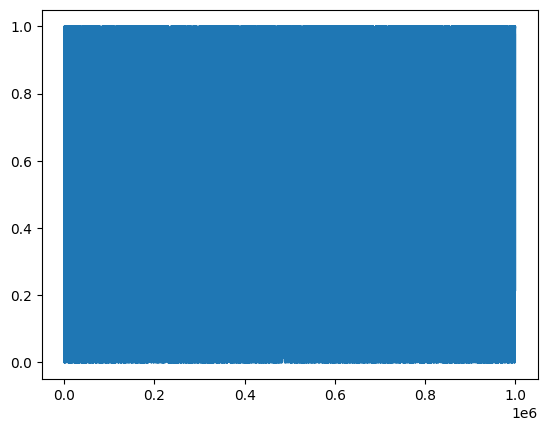

RMS shift 3.0000000000000004
RMS shift diff 0.3169527515419685


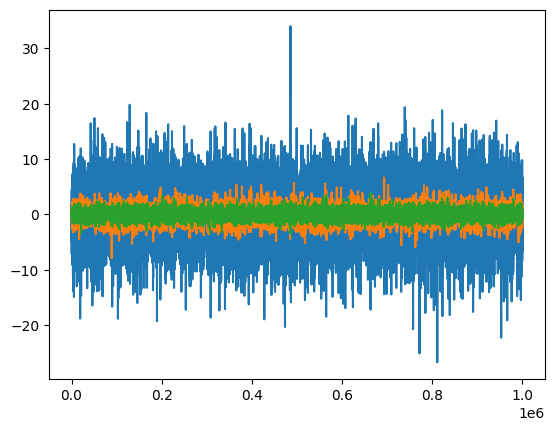

In [144]:
plt.plot(envelope)
plt.show()

plt.plot(motion.T)

print("RMS shift", np.sqrt(np.mean(np.sum(motion**2, 0))))
sq = np.diff(motion, axis=-1)**2
print("RMS shift diff", np.sqrt(np.mean(sq.sum(0), -1)))

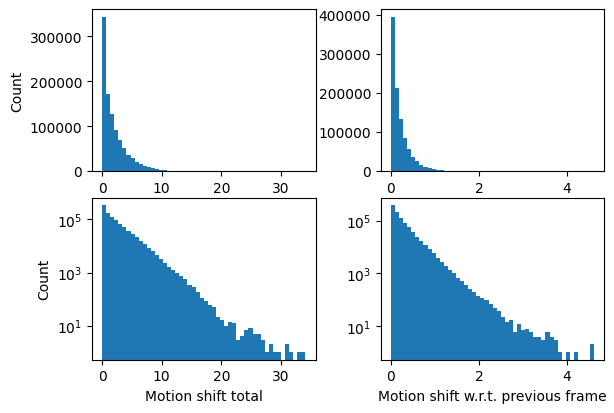

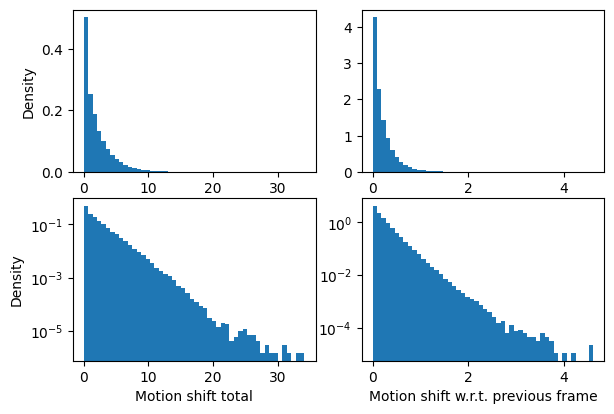

In [145]:
def calc_shifts(key="total"):
    if key=="total":
        sq = (motion - motion.mean(-1)[..., None])**2
    else:
        sq = np.diff(motion, axis=-1)**2
    return np.sqrt(sq.sum(0))

for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), 50, log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count") 
    plt.tight_layout(pad=.2)

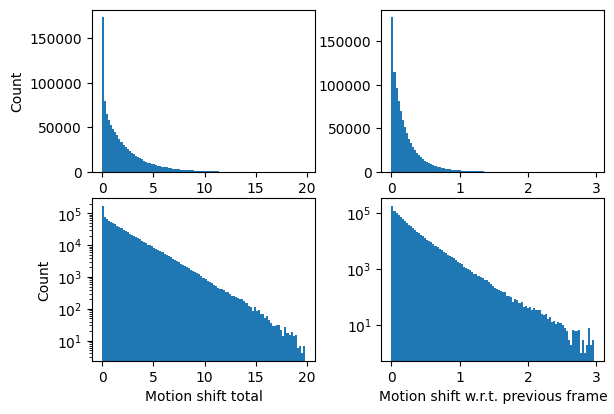

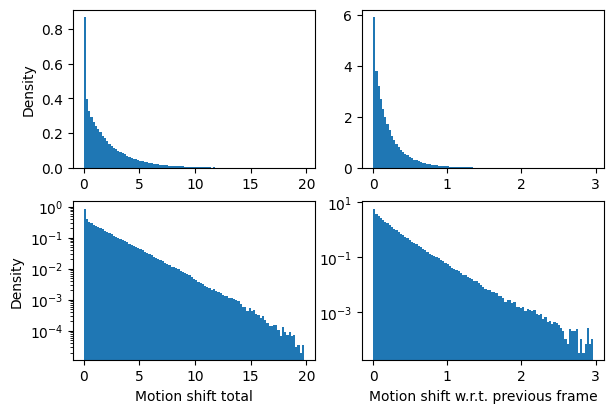

In [146]:
for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), np.arange(0,20,.2) if key=="total" else np.arange(0,3,.03), log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count")            
    plt.tight_layout(pad=.2)

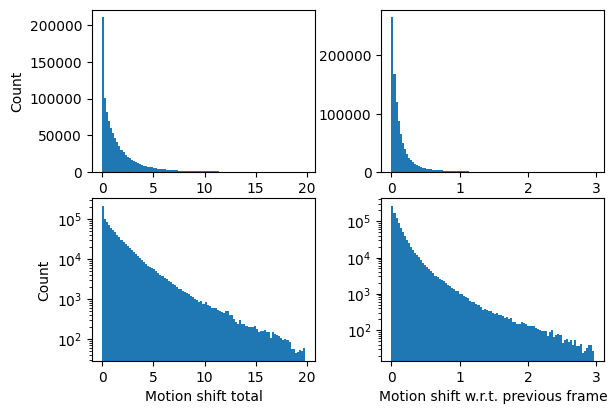

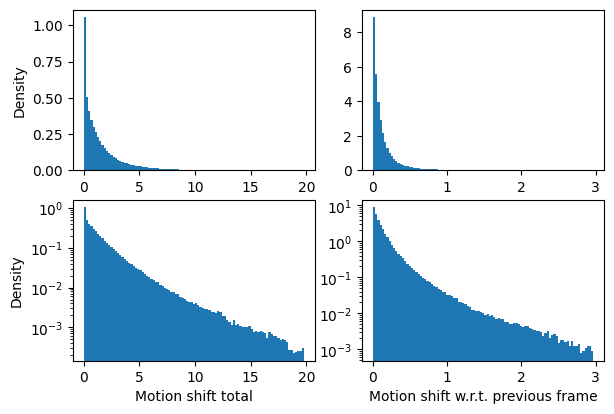

In [ ]:
for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), np.arange(0,20,.2) if key=="total" else np.arange(0,3,.03), log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count")            
    plt.tight_layout(pad=.2)

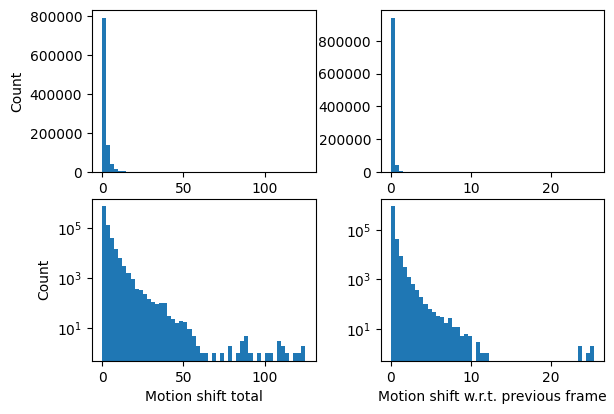

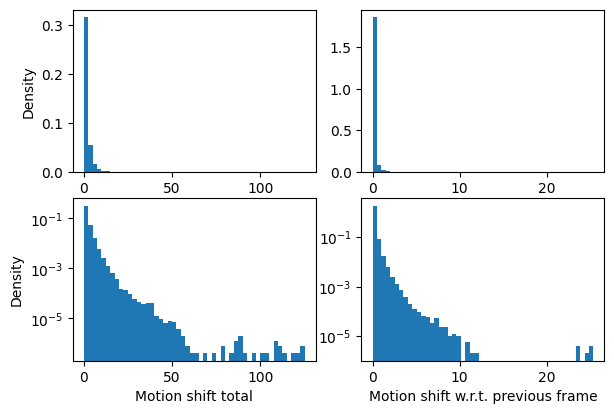

In [129]:
def calc_shifts(key="total"):
    if key=="total":
        sq = (motion - motion.mean(-1)[..., None])**2
    else:
        sq = np.diff(motion, axis=-1)**2
    return np.sqrt(sq.sum(0))

for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), 50, log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count") 
    plt.tight_layout(pad=.2)

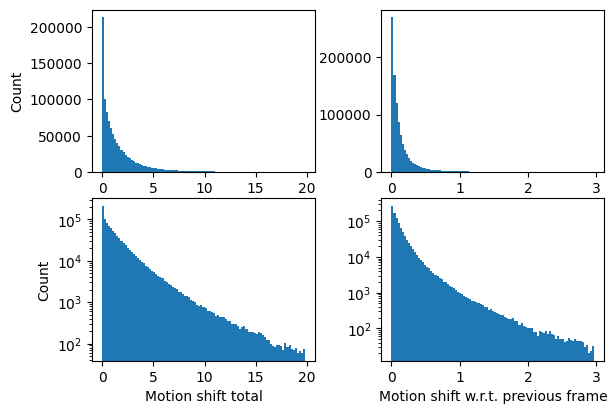

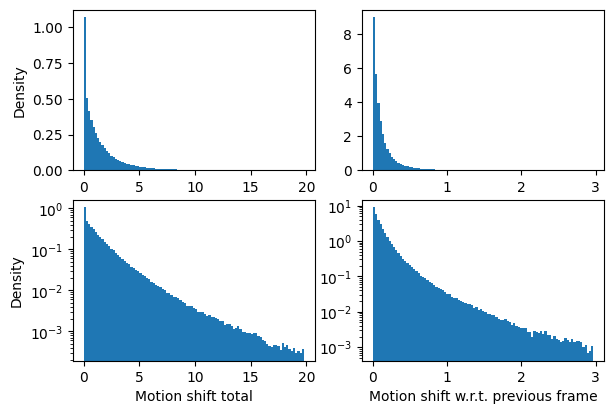

In [130]:
for density in (False, True): 
    plt.figure(figsize=(6,4))
    for key in ("total", "w.r.t. previous frame"):
        shifts=calc_shifts(key=key)
        for log in (0,1):
            plt.subplot(2,2,(1 if key=="total" else 2)+2*log)
            plt.hist(shifts.ravel(), np.arange(0,20,.2) if key=="total" else np.arange(0,3,.03), log=log, density=density)
            if log:
                plt.xlabel(f"Motion shift {key}")
            if key=="total":
                plt.ylabel("Density" if density else "Count")            
    plt.tight_layout(pad=.2)

In [83]:
np.exp(-10000*0.0023/360), np.exp(-100000*0.0023/360)

(0.9381092280988239, 0.5278786301239432)